# Extração de Embeddings Faciais para Detecção de Bocejo

Esta célula realiza a extração de embeddings (representações vetoriais) dos pontos da boca em imagens, utilizando a biblioteca MediaPipe para detecção de landmarks faciais. O objetivo é obter uma representação normalizada da região da boca para cada imagem, que será utilizada posteriormente para treinar modelos de detecção de bocejo.

**Principais etapas:**

- Definição dos diretórios de imagens com e sem bocejo.
- Lista dos índices dos landmarks da boca.
- Inicialização do detector de face mesh do MediaPipe.
- Função `centralizar_normalizar`: centraliza e normaliza os pontos da boca para remover variações de escala e posição.
- Função `embedar_mapeamento`: carrega uma imagem, detecta os landmarks da boca e retorna suas coordenadas normalizadas.

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os

pasta_1 = "train/no_yawn"
pasta_2 = "train/yawn"
mouth_landmarks = [
    61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308, 324, 318, 402, 317,
    14, 87, 178, 88, 95, 185, 40, 39, 37, 0, 267, 269, 270, 409, 415, 310, 311,
    312, 13, 82, 81, 42, 183, 78, 50, 280, 152, 377, 400, 164, 393
]

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)


def centralizar_normalizar(pontos: np.ndarray) -> np.ndarray:

    pontos = np.array(pontos)
    if pontos.ndim == 1:
        pontos = pontos.reshape(-1, 2)
    
    centroide = pontos.mean(axis=0)
    pontos_centralizados = pontos - centroide
    
    norma = np.linalg.norm(pontos_centralizados, axis=1).max()
    if norma == 0:
        norma = 1
    pontos_normalizados = pontos_centralizados / norma
    
    return np.array(pontos_normalizados)


def embedar_mapeamento(path: str, pasta: str) -> list[int]:

    caminho = os.path.join(pasta, path)
    image = cv2.imread(caminho)

    if image is None:
        print(f"Erro ao carregar a imagem: {path}")
        

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    coords = []

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            height, width, _ = image.shape
            for idx in mouth_landmarks:
                lm = face_landmarks.landmark[idx]
                x = int(lm.x * width)
                y = int(lm.y * height)
                coords += [x, y]
                cv2.circle(image, (x, y), 1, (0, 255, 0), -1)
                
    return coords

# Extração e Normalização dos Embeddings Faciais

**Objetivo:** extrair embeddings (coordenadas dos pontos da boca) das imagens das classes `no_yawn` e `yawn`, **centralizar/normalizar** e consolidar tudo em um único array para visualização e treinamento.

## Etapas

1. **Inicialização**
   - Criar lista vazia `images_coords` para armazenar os embeddings.

2. **Processamento — `no_yawn`**
   - Listar arquivos em `no_yawn/`.
   - Para cada arquivo:
     - Extrair pontos da boca com `embedar_mapeamento(...)`.
     - Se bem-sucedido, aplicar `centralizar_normalizar(...)` (centraliza e normaliza os pontos).
     - Adicionar o embedding resultante à lista `images_coords`.

3. **Processamento — `yawn`**
   - Repetir o mesmo procedimento para o diretório `yawn/`.

4. **Conversão para NumPy**
   - Converter `images_coords` para `numpy.ndarray`.
   - Aplicar `reshape` para garantir vetor 1D por amostra:
     - `images_coords = images_coords.reshape(len(images_coords), -1)`
     - Forma final esperada: `(n_amostras, n_features)`.

5. **Informações/Log**
   - Imprimir o **total de embeddings** extraídos.
   - Exibir o **shape** do array final (`images_coords.shape`).

## Resultado

- Array **`images_coords`** contendo embeddings **centralizados e normalizados** das duas classes, pronto para:
  - **Visualização** (ex.: t-SNE, PCA);
  - **Treinamento** (classificadores/detectores).


In [ ]:
images_coords = []

lista_1 = os.listdir(pasta_1)
for nome_arquivo in lista_1:
    coords = embedar_mapeamento(nome_arquivo, pasta_1)
    if coords:
        images_coords.append(centralizar_normalizar(coords))

print(len(images_coords))

lista_2 = os.listdir(pasta_2)
for nome_arquivo in lista_2:
    coords = embedar_mapeamento(nome_arquivo, pasta_2)
    if coords:
        images_coords.append(centralizar_normalizar(coords))


images_coords = np.array(images_coords)
images_coords = images_coords.reshape(images_coords.shape[0], -1)
print(len(images_coords), images_coords.shape)

1831
3373 (3373, 94)


# Visualização dos Embeddings com t‑SNE (Resumo)

**Objetivo:** reduzir a dimensionalidade dos **embeddings das bocas** e **visualizar** como as classes **Sem bocejo** e **Com bocejo** se distribuem em 2D, verificando se existe **separação** clara entre elas.

## O que foi feito
1. **Configuração do estilo** no `matplotlib` (tema, fonte, tamanho da figura) para tornar o gráfico legível.
2. **Redução com t‑SNE** para 2 dimensões a partir dos embeddings de boca.
3. **Plotagem dos pontos**:
   - **Sem bocejo**: `tsne_vector[:1839]` (marcador circular).
   - **Com bocejo**: `tsne_vector[1839:]` (marcador triangular).
   - Cada ponto representa **uma imagem**, posicionada pelas **duas componentes** do t‑SNE.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_vector = tsne.fit_transform(images_coords)

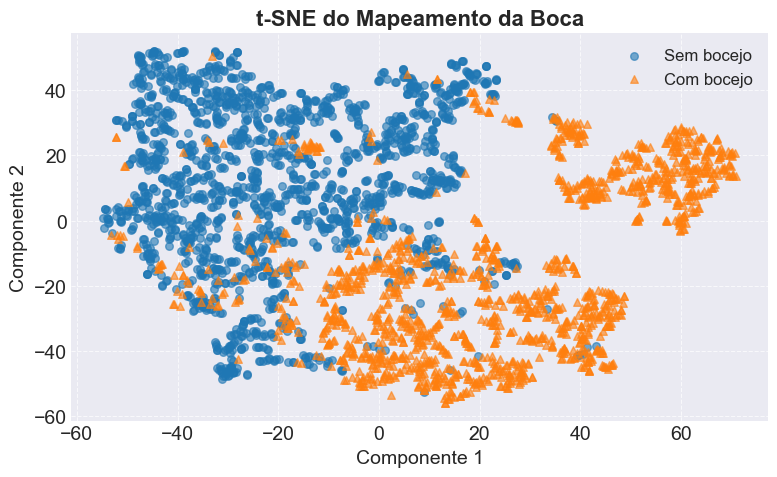

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 13,
    'figure.figsize': (8, 5),
    'axes.titleweight': 'bold'
})

plt.scatter(tsne_vector[:1839, 0], tsne_vector[:1839, 1], color="#1f77b4", alpha=0.6, s=30, marker='o', label='Sem bocejo')
plt.scatter(tsne_vector[1839:, 0], tsne_vector[1839:, 1], color="#ff7f0e", alpha=0.6, s=30, marker='^', label='Com bocejo')

plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('t-SNE do Mapeamento da Boca')
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

tensor_yawn = torch.tensor(images_coords[0:1839], dtype=torch.float32)
tensor_no_yawn = torch.tensor(images_coords[1839:], dtype=torch.float32)
label_yawn = torch.zeros(len(images_coords[0:1839]), dtype=torch.long)
label_no_yawn = torch.ones(len(images_coords[1839:]), dtype=torch.long)

X = torch.cat([tensor_yawn, tensor_no_yawn], dim=0)
y = torch.cat([label_yawn, label_no_yawn], dim=0)

dataset = TensorDataset(X, y)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

import torch.nn as nn
import torch.nn.functional as F

class YawnClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fully_connected1 = nn.Linear(input_dim, 128)  
        self.fully_connected2 = nn.Linear(128, 64)         
        self.fully_connected3 = nn.Linear(64, 2)           

    def forward(self, x):
        x = F.relu(self.fully_connected1(x))  
        x = F.relu(self.fully_connected2(x))
        x = self.fully_connected3(x)          
        return x

model = YawnClassifier(X.shape[1])

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train() 
    ac_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()  
        outputs = model(batch_X)  
        loss = criterion(outputs, batch_y) 
        loss.backward()  
        optimizer.step()  
        ac_loss += loss.item()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {ac_loss / len(train_loader)}")


correct = 0
total = 0
model.eval()  
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


def predict_book_type(embedding):
    embedding = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0)  # (1, dim)
    model.eval()
    with torch.no_grad():
        output = model(embedding)
        _, predicted = torch.max(output, 1)
    return "No Yawn" if predicted.item() == 1 else "Yawn"

D = X.shape[1]                     
dummy_input = torch.randn(1, D)    

with torch.no_grad():
    traced = torch.jit.trace(model, dummy_input)
    traced.save("models/yawn_model_full.ts")


Epoch 1, Loss: 0.4250295289252934
Epoch 11, Loss: 0.18034980900977787
Epoch 21, Loss: 0.15132884610640376
Epoch 31, Loss: 0.12756793395076926
Epoch 41, Loss: 0.11780911148770859
Epoch 51, Loss: 0.10292201322552405
Epoch 61, Loss: 0.09672267917347582
Epoch 71, Loss: 0.08751707147610815
Epoch 81, Loss: 0.08143422968293491
Epoch 91, Loss: 0.07585750225147134
Epoch 101, Loss: 0.07531224505877808
Epoch 111, Loss: 0.06735768178968053
Epoch 121, Loss: 0.06369164182657475
Epoch 131, Loss: 0.066901826672256
Epoch 141, Loss: 0.05931478431448341
Epoch 151, Loss: 0.06644854214973747
Epoch 161, Loss: 0.05751743127444857
Epoch 171, Loss: 0.057090285307678734
Epoch 181, Loss: 0.0480633092553992
Epoch 191, Loss: 0.05205713773121763
Accuracy: 96.75%


In [ ]:
import torch
torch.save(model.state_dict(), "models/yawn_model_onnx.pth")
